In [385]:
import pandas as pd 
import numpy as np 
import os
import math
import joblib
import kaleido
import plotly.express as px 
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold

from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from config.path_config import ROOT_DIR
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display



InteractiveShell.ast_node_interactivity = "all"



TARGET = "SeriousDlqin2yrs"
RAW_DATA_PATH = os.path.join(ROOT_DIR,"data","raw","cs-training.csv")
TEST_DATA_PATH = os.path.join(ROOT_DIR,"data","raw","cs-test.csv")
SAMPLE_SUBMISSION = os.path.join(ROOT_DIR,"data","raw","sampleEntry.csv")

### Helper Function

In [386]:

#outlier removal 
def outlier_treatment(data,col):
    q1,q3 = np.percentile(data[col] ,[25,75])
    iqr = q3-q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    lower_range,upper_range
    data = data.drop(data[ (data[col] > upper_range) | (data[col] < lower_range) ].index )
    return data




## Loading Data

In [387]:
data = pd.read_csv(RAW_DATA_PATH)

## Dropping Unused Columns 

In [388]:
data.drop('Unnamed: 0',axis=1,inplace=True)

## Sanity Check

In [389]:
#head
data.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


In [390]:
data.dtypes
#overall data types are the same as description on .xls file 

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [391]:
# check duplicated data 
data.duplicated().sum()
data = data.drop_duplicates()

609

In [392]:
#missing values percentage
(data.isnull().sum()/data.shape[0])*100
# we got pretty much missing values in monthly income however it still under third of the dataset

SeriousDlqin2yrs                         0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.560081
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.562403
dtype: float64

## Removing Outlier

In [393]:
#outlier removal 
# i remove outlier not in all columns its because there are several accounts i want to keep its information variance. such as number of days late and number of open credit
data = outlier_treatment(data,col='MonthlyIncome')
data = outlier_treatment(data,col='RevolvingUtilizationOfUnsecuredLines')
data = outlier_treatment(data,col='DebtRatio')
data = outlier_treatment(data,col='age') 

In [394]:
## 

## Exploratory Data Analysis

## Missing Values Imputation 
from previous viz the distribution of the monthlyincome is skewed imputation using mean is not wise hence, imputation using median is favorable. 
For categorical variable such us number of dependents we will use mode imputation

In [395]:
##Imputation 
data['MonthlyIncome'] = data['MonthlyIncome'].fillna(data['MonthlyIncome'].median())
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(data['NumberOfDependents'].mode()[0])

In [396]:
## Feature Engineering 
data['LogMonthlyIncome'] = np.log1p(data['MonthlyIncome'])

## Create Binning
The Process of deciding bin size is still heuristic groupping Approach. Another Alternative is that you can use decision tree binning, split into equal length binning, and etc. 
My approach quite simple. I create the table of pct change of class 1 distribution among each value ( if discrete such as age) if the variable / feature is contiunous sucj as monhtlyincon,revolving,debtratio we can use q cut to split into quantiles (5 quantiles) and get the the bin range. The reason i did this is for applying same feature transformation to incoming data. 

### Binning Range

In [397]:
age_binning = [-math.inf, 20,25,30,35, 40,45, 50,55,60,65, 70, math.inf]
dependent_bin = [-math.inf,0,1,2,3,4,5,6,7,8,math.inf]
dependent_binning = [0,2,4,5,6,7,8,9,math.inf]
binning_late_90days = [-math.inf,0,1,2,3,4,5,6,7,8,9,10,math.inf]
binning_late_3059days = [-math.inf,0,1,2,3,4,5,6,7,8,9,10,math.inf]
binning_late_6089days = [-math.inf,0,1,2,3,4,5,6,7,8,9,10,math.inf]
interval_revolving_rate = [-math.inf,0.000, 0.00342,0.0215,0.0489,0.0954,0.174,0.297,0.468,0.708,0.973,math.inf]
debt_ratio_interval = [-math.inf,0.000,0.0144,0.0954,0.165,0.226,0.284,0.346,0.417,0.512,0.684,1.903,math.inf]
monthlyincome_interval = [-math.inf,3198.0, 4755.0, 6400.0, 9150.0,math.inf]
logmonthlyincome_interval = [-math.inf,0.001, 7.748,8.071,8.294,8.467,8.613,8.764,8.927,9.122,9.365,14.917,math.inf]
creditlines_interval  = [-math.inf,1,2,3,4.0,5,6,7,8, 9.0, 12.0,math.inf]
realestatelines_interval = [-math.inf,1,2,3,4.0,5,6,7,8, 9.0, 12.0,math.inf]

def create_binning(data) : 
    data['bin_age'] = pd.cut(data['age'],bins=age_binning).astype('str')
    data['bin_NumberOfDependents'] = pd.cut(data['NumberOfDependents'],bins=dependent_bin).astype('str')
    data['bin_NumberOfTimes90DaysLate'] = pd.cut(data['NumberOfTimes90DaysLate'],bins=binning_late_90days).astype('str')
    data['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(data['NumberOfTime30-59DaysPastDueNotWorse'], bins=binning_late_3059days).astype('str')
    data['bin_NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(data['NumberOfTime60-89DaysPastDueNotWorse'], bins=binning_late_6089days).astype('str')

    data['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.cut(data['RevolvingUtilizationOfUnsecuredLines'],bins=interval_revolving_rate).astype('str')
    data['bin_DebtRatio'] = pd.cut(data['DebtRatio'],bins=debt_ratio_interval).astype('str')
    data['bin_MonthlyIncome'] = pd.cut(data['MonthlyIncome'],bins=monthlyincome_interval).astype('str')
    data['bin_NumberOfOpenCreditLinesAndLoans'] = pd.cut(data['NumberOfOpenCreditLinesAndLoans'],bins=creditlines_interval).astype('str')
    data['bin_NumberRealEstateLoansOrLines'] = pd.cut(data['NumberRealEstateLoansOrLines'],bins=realestatelines_interval).astype('str')
    return data

In [398]:
binned_data = data.pipe(create_binning)

## Binned Data

In [399]:
binned_data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,bin_age,bin_NumberOfDependents,bin_NumberOfTimes90DaysLate,bin_NumberOfTime30-59DaysPastDueNotWorse,bin_NumberOfTime60-89DaysPastDueNotWorse,bin_RevolvingUtilizationOfUnsecuredLines,bin_DebtRatio,bin_MonthlyIncome,bin_NumberOfOpenCreditLinesAndLoans,bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,"(40.0, 45.0]","(1.0, 2.0]","(-inf, 0.0]","(1.0, 2.0]","(-inf, 0.0]","(0.708, 0.973]","(0.684, 1.903]","(6400.0, 9150.0]","(12.0, inf]","(5.0, 6.0]"
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,"(35.0, 40.0]","(0.0, 1.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(0.708, 0.973]","(0.0954, 0.165]","(-inf, 3198.0]","(3.0, 4.0]","(-inf, 1.0]"
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,"(35.0, 40.0]","(-inf, 0.0]","(0.0, 1.0]","(0.0, 1.0]","(-inf, 0.0]","(0.468, 0.708]","(0.0144, 0.0954]","(-inf, 3198.0]","(1.0, 2.0]","(-inf, 1.0]"
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,"(25.0, 30.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(0.174, 0.297]","(0.0144, 0.0954]","(3198.0, 4755.0]","(4.0, 5.0]","(-inf, 1.0]"
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,"(45.0, 50.0]","(-inf, 0.0]","(-inf, 0.0]","(0.0, 1.0]","(-inf, 0.0]","(0.708, 0.973]","(0.0144, 0.0954]","(9150.0, inf]","(6.0, 7.0]","(-inf, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,...,"(45.0, 50.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(0.297, 0.468]","(0.346, 0.417]","(3198.0, 4755.0]","(6.0, 7.0]","(-inf, 1.0]"
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,"(70.0, inf]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(0.0215, 0.0489]","(0.165, 0.226]","(-inf, 3198.0]","(3.0, 4.0]","(-inf, 1.0]"
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,"(40.0, 45.0]","(1.0, 2.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(0.297, 0.468]","(0.684, 1.903]","(4755.0, 6400.0]","(3.0, 4.0]","(-inf, 1.0]"
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,"(25.0, 30.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(-inf, 0.0]","(4755.0, 6400.0]","(3.0, 4.0]","(-inf, 1.0]"


## Calculate Weight of Evidence 

\begin{align}
\text{Weight of Evidence:}
\ln
\text{Distribution
\end{align}



In [400]:
binned_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'LogMonthlyIncome', 'bin_age',
       'bin_NumberOfDependents', 'bin_NumberOfTimes90DaysLate',
       'bin_NumberOfTime30-59DaysPastDueNotWorse',
       'bin_NumberOfTime60-89DaysPastDueNotWorse',
       'bin_RevolvingUtilizationOfUnsecuredLines', 'bin_DebtRatio',
       'bin_MonthlyIncome', 'bin_NumberOfOpenCreditLinesAndLoans',
       'bin_NumberRealEstateLoansOrLines'],
      dtype='object')

In [401]:
def create_woe_reference(feature) :
    crosstab_data = (pd.crosstab(binned_data[feature],
                binned_data[TARGET],rownames=[feature], 
                colnames=[TARGET])
                .reset_index()
                )
    total_0 = np.sum(crosstab_data[0])
    total_1 = np.sum(crosstab_data[1])

    crosstab_data[0] = crosstab_data[0]/total_0
    crosstab_data[1] = crosstab_data[1]/total_1

    crosstab_data[f'{feature}_woe'] = np.log(crosstab_data[0]/crosstab_data[1])
    crosstab_data[f'{feature}_iv'] = (crosstab_data[0]-crosstab_data[1])*crosstab_data[f'{feature}_woe']
    
    temp  = {}
    for x,y,z in zip (crosstab_data[feature],
                  crosstab_data[f'{feature}_woe'],crosstab_data[f'{feature}_iv']
                 ) : 
        
    	temp[x] = {'woe':y,'iv':z}

    temp
    return temp

In [402]:
binned_col = [x for x in binned_data.columns if x.startswith('bin')]
woe_reference = {}
for feature in binned_col : 
    woe_reference[feature] = create_woe_reference(feature)


In [403]:
joblib.dump(woe_reference,'woe_reference.joblib')

['woe_reference.joblib']

In [404]:
woe_reference

{'bin_age': {'(20.0, 25.0]': {'woe': -0.5029778008571553,
   'iv': 0.006114302046664361},
  '(25.0, 30.0]': {'woe': -0.5744835047352527, 'iv': 0.02306912293486296},
  '(30.0, 35.0]': {'woe': -0.44273113180112517, 'iv': 0.01834339827340103},
  '(35.0, 40.0]': {'woe': -0.29524942339237314, 'iv': 0.009538179102773575},
  '(40.0, 45.0]': {'woe': -0.21493823443427776, 'iv': 0.005784051013270645},
  '(45.0, 50.0]': {'woe': -0.1728852313034842, 'iv': 0.00420029323227334},
  '(50.0, 55.0]': {'woe': -0.035912776219466286, 'iv': 0.00015882672214590274},
  '(55.0, 60.0]': {'woe': 0.2342845364331494, 'iv': 0.0055225069026100795},
  '(60.0, 65.0]': {'woe': 0.532489628459634, 'iv': 0.023401830509758165},
  '(65.0, 70.0]': {'woe': 0.926085919972863, 'iv': 0.03939504116655464},
  '(70.0, inf]': {'woe': 1.0603505244294575, 'iv': 0.07594171159791153}},
 'bin_NumberOfDependents': {'(-inf, 0.0]': {'woe': 0.16192507634701706,
   'iv': 0.013369760082315225},
  '(0.0, 1.0]': {'woe': -0.06715983128081378, 'iv

In [405]:
woe_reference
#calculate information value for each column 
iv_features = {}
for feature in woe_reference.keys() : 
    feature_info_dict = woe_reference.get(feature)
    temp = 0 
    for bin_size in feature_info_dict.keys() : 
        val = feature_info_dict.get(bin_size)['iv']
        if val == np.inf : 
            temp+=0 
        else : 
            temp+=val
    iv_features[feature] = temp

{'bin_age': {'(20.0, 25.0]': {'woe': -0.5029778008571553,
   'iv': 0.006114302046664361},
  '(25.0, 30.0]': {'woe': -0.5744835047352527, 'iv': 0.02306912293486296},
  '(30.0, 35.0]': {'woe': -0.44273113180112517, 'iv': 0.01834339827340103},
  '(35.0, 40.0]': {'woe': -0.29524942339237314, 'iv': 0.009538179102773575},
  '(40.0, 45.0]': {'woe': -0.21493823443427776, 'iv': 0.005784051013270645},
  '(45.0, 50.0]': {'woe': -0.1728852313034842, 'iv': 0.00420029323227334},
  '(50.0, 55.0]': {'woe': -0.035912776219466286, 'iv': 0.00015882672214590274},
  '(55.0, 60.0]': {'woe': 0.2342845364331494, 'iv': 0.0055225069026100795},
  '(60.0, 65.0]': {'woe': 0.532489628459634, 'iv': 0.023401830509758165},
  '(65.0, 70.0]': {'woe': 0.926085919972863, 'iv': 0.03939504116655464},
  '(70.0, inf]': {'woe': 1.0603505244294575, 'iv': 0.07594171159791153}},
 'bin_NumberOfDependents': {'(-inf, 0.0]': {'woe': 0.16192507634701706,
   'iv': 0.013369760082315225},
  '(0.0, 1.0]': {'woe': -0.06715983128081378, 'iv

In [406]:
iv_features

{'bin_age': 0.21146926350222622,
 'bin_NumberOfDependents': 0.03365789301516327,
 'bin_NumberOfTimes90DaysLate': 0.8196840039171406,
 'bin_NumberOfTime30-59DaysPastDueNotWorse': 0.7229398311405594,
 'bin_NumberOfTime60-89DaysPastDueNotWorse': 0.5580029928200114,
 'bin_RevolvingUtilizationOfUnsecuredLines': 1.0301175740887492,
 'bin_DebtRatio': 0.10887772684470236,
 'bin_MonthlyIncome': 0.0820743428941619,
 'bin_NumberOfOpenCreditLinesAndLoans': 0.09194120187506187,
 'bin_NumberRealEstateLoansOrLines': 0.02210886960476401}

In [407]:
def get_woe_value(x,col,woe_reference=woe_reference) :
    try : 
        
        ref = woe_reference.get(col) 
        return ref.get(x)['woe'] 
    except : 
        print(f'value of x : {x}, col = {col}')
        return 0

In [408]:
## Creating Feature from calculated woe
for feature in binned_col : 
    binned_data[f'woe_{feature}'] = binned_data[feature].apply(get_woe_value,col=feature)

In [409]:
binned_data= binned_data.replace([np.inf, -np.inf], 0)

## Encoding

In [410]:
from sklearn.preprocessing import LabelEncoder
for col in binned_col : 
    encoder = LabelEncoder()
    binned_data[f'encoded_{col}'] = encoder.fit_transform(binned_data[col].to_numpy().reshape(-1,1))
    joblib.dump(encoder,f'encoder_{col}.joblib')

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_age.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberOfDependents.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberOfTimes90DaysLate.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberOfTime30-59DaysPastDueNotWorse.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberOfTime60-89DaysPastDueNotWorse.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_RevolvingUtilizationOfUnsecuredLines.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_DebtRatio.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_MonthlyIncome.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberOfOpenCreditLinesAndLoans.joblib']

/home/fakhri/pacmann_project/project_env/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



['encoder_bin_NumberRealEstateLoansOrLines.joblib']

In [411]:
binned_data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,encoded_bin_age,encoded_bin_NumberOfDependents,encoded_bin_NumberOfTimes90DaysLate,encoded_bin_NumberOfTime30-59DaysPastDueNotWorse,encoded_bin_NumberOfTime60-89DaysPastDueNotWorse,encoded_bin_RevolvingUtilizationOfUnsecuredLines,encoded_bin_DebtRatio,encoded_bin_MonthlyIncome,encoded_bin_NumberOfOpenCreditLinesAndLoans,encoded_bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,4,2,0,2,0,9,10,3,2,6
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,3,1,0,0,0,9,3,0,4,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,3,0,1,1,0,8,2,0,1,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,1,0,0,0,0,6,2,1,5,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,5,0,0,1,0,9,2,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,...,5,0,0,0,0,7,7,1,7,0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,10,0,0,0,0,3,4,0,4,0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,4,2,0,0,0,7,10,2,4,0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,1,0,0,0,0,0,0,2,4,0


## Data Splittting

In [412]:
woe_col = [x for x in binned_data.columns if x.startswith('woe')]
encoded_col = [x for x in binned_data.columns if x.startswith('encoded')]
X = binned_data[woe_col]
y = binned_data[TARGET]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


## Training_Models

In [413]:

fold = StratifiedKFold(5)
def begin_cross_validation(X,Y,model,fold=fold) : 
    scoring_dict = {'auc':[]}
    for train_idx,test_idx in fold.split(X,Y) : 
        train_x,val_x = X.iloc[train_idx],X.iloc[test_idx]
        train_y,val_y = Y.iloc[train_idx],Y.iloc[test_idx]
        #train model 

        model.fit(train_x,train_y)
        y_pred = model.predict_proba(val_x)
        #calculate metrics 
        scoring_dict["auc"].append(metrics.roc_auc_score(val_y, y_pred[:, 1]))


    #print the scoring 
    print(f'''Scoring: AUC :{np.mean(scoring_dict['auc'])}
     ''')
    return np.mean(scoring_dict['auc'])

In [436]:
base_logistic_model = LogisticRegression()
clf_model = LogisticRegression(class_weight='balanced',max_iter=100)
begin_cross_validation(X,y,model=clf_model)

Scoring: AUC :0.848427919761205
     


0.848427919761205

In [437]:
base_logistic_model.fit(X_train,y_train)
clf_model.fit(X_train,y_train)
y_pred = clf_model.predict_proba(X_test)[:,1]

LogisticRegression()

LogisticRegression(class_weight='balanced')

## Model Evaluation

### AUCurve

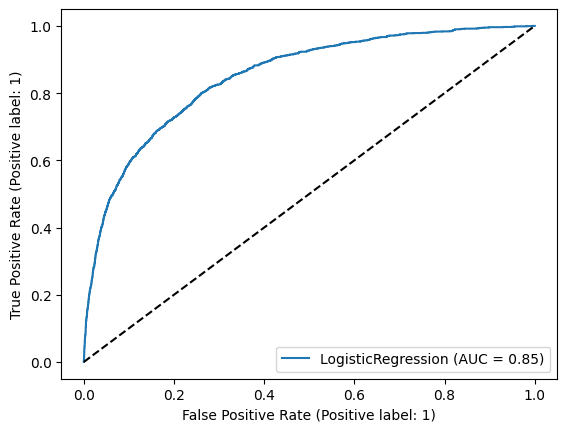

In [416]:
from sklearn.metrics import RocCurveDisplay
x = RocCurveDisplay.from_estimator(
   clf_model, X_test, y_test)
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.show()


## Calibration Plot

LogisticRegression()

LogisticRegression(class_weight='balanced')

Text(0.5, 1.0, 'Calibration plots (Logistic Regression)')

(array([19811.,  2042.,   607.,   323.,   218.,   167.,   128.,    86.,
           58.,    47.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

[Text(0.5, 1.0, 'Logistic Regression base'),
 Text(0.5, 0, 'Mean predicted probability'),
 Text(0, 0.5, 'Count')]

(array([1725., 6601., 4760., 2772., 2208., 1800., 1211.,  799.,  695.,
         916.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

[Text(0.5, 1.0, 'Logistic Regression class_weight=balanced'),
 Text(0.5, 0, 'Mean predicted probability'),
 Text(0, 0.5, 'Count')]

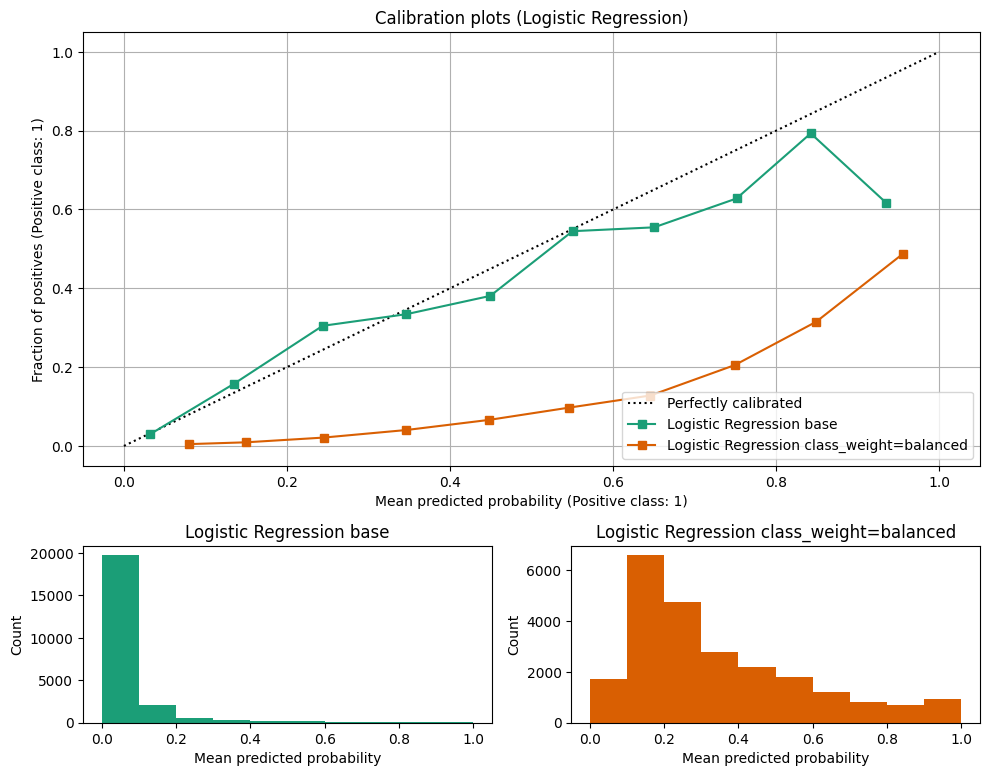

In [438]:
from matplotlib.gridspec import GridSpec
clf_list = [(base_logistic_model,'Logistic Regression base'),
    (clf_model,'Logistic Regression class_weight=balanced'),
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Logistic Regression)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Confusion Metrics

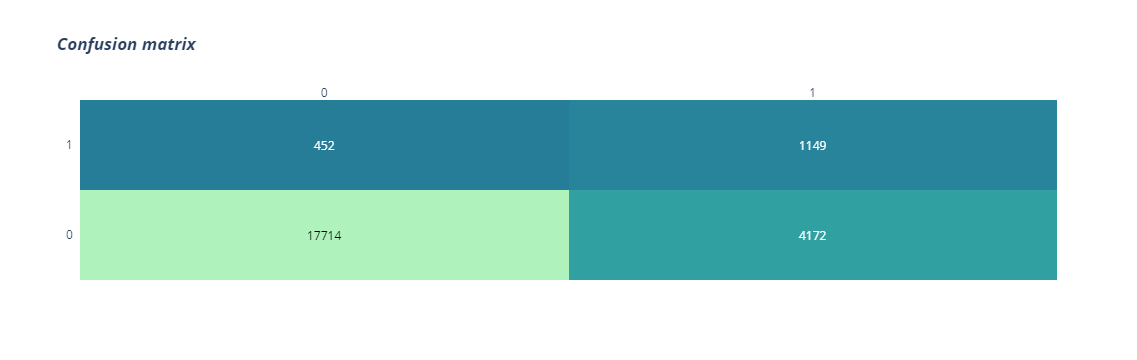

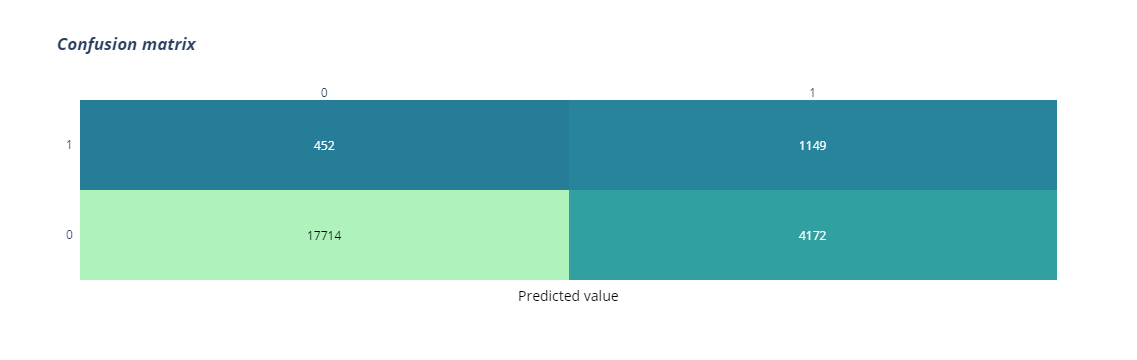

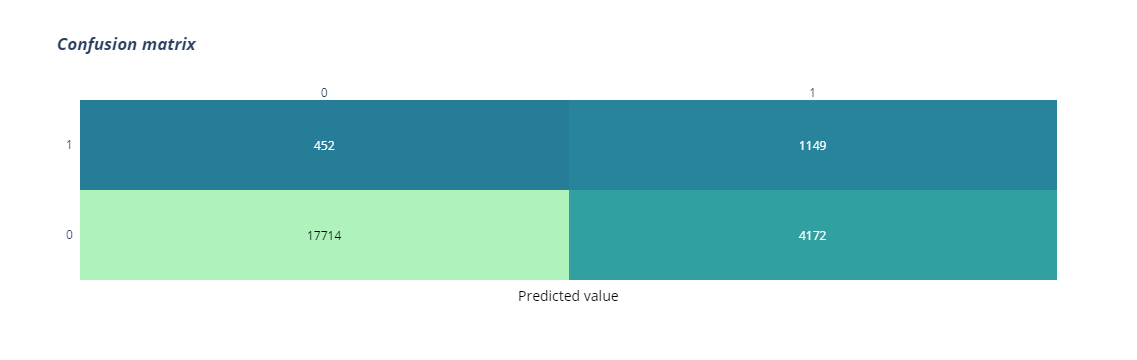

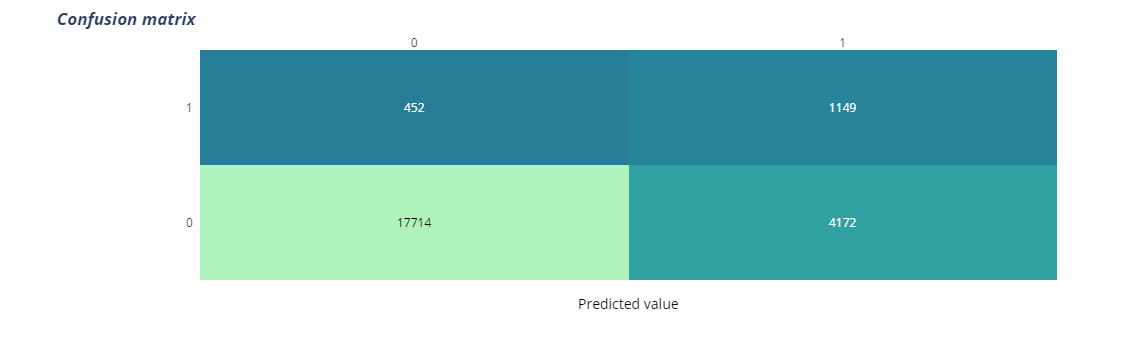

In [418]:
import plotly.figure_factory as ff

y_pred = clf_model.predict(X_test)
conf_metrics =  metrics.confusion_matrix(y_test,y_pred)
x = ['0','1']
y =  ['0','1']

# change each element of z to type string for annotations
z_text = [[str(y) for y in x] for x in conf_metrics]

# set up figure 
fig = ff.create_annotated_heatmap(conf_metrics, x=x, y=y, colorscale='tealgrn_r')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))



In [419]:
X_test.columns

Index(['woe_bin_age', 'woe_bin_NumberOfDependents',
       'woe_bin_NumberOfTimes90DaysLate',
       'woe_bin_NumberOfTime30-59DaysPastDueNotWorse',
       'woe_bin_NumberOfTime60-89DaysPastDueNotWorse',
       'woe_bin_RevolvingUtilizationOfUnsecuredLines', 'woe_bin_DebtRatio',
       'woe_bin_MonthlyIncome', 'woe_bin_NumberOfOpenCreditLinesAndLoans',
       'woe_bin_NumberRealEstateLoansOrLines'],
      dtype='object')

In [420]:
importance = permutation_importance(clf_model, X_test, y_test,
                           n_repeats=30,
                           random_state=0,
                                   scoring='roc_auc')

importance_df = pd.DataFrame()
features = []
mean_importance = []
std_importance= []

In [421]:

for i in importance['importances_mean'].argsort()[::-1]:
    if importance['importances_mean'][i] - 2 * importance['importances_std'][i] > 0:
        features.append(X.columns[i])
        mean_importance.append(importance['importances_mean'][i])
        std_importance.append(importance['importances_std'][i])
        print(f"{X.columns[i]}"
              f"{importance['importances_mean'][i]:.3f}"
              f" +/- {importance['importances_std'][i]:.3f}")
        
        
importance_df = pd.DataFrame(data={"features":features,
                                   "mean_importance":mean_importance,
                                  "std_importance":std_importance})
importance_df.style.highlight_max(color = 'green',subset='mean_importance')

woe_bin_RevolvingUtilizationOfUnsecuredLines0.076 +/- 0.003
woe_bin_NumberOfTime30-59DaysPastDueNotWorse0.032 +/- 0.002
woe_bin_NumberOfTimes90DaysLate0.030 +/- 0.001
woe_bin_NumberOfTime60-89DaysPastDueNotWorse0.012 +/- 0.001
woe_bin_DebtRatio0.006 +/- 0.001
woe_bin_age0.005 +/- 0.001
woe_bin_NumberRealEstateLoansOrLines0.002 +/- 0.000


,features,mean_importance,std_importance
0,woe_bin_RevolvingUtilizationOfUnsecuredLines,0.076259,0.003363
1,woe_bin_NumberOfTime30-59DaysPastDueNotWorse,0.031947,0.002243
2,woe_bin_NumberOfTimes90DaysLate,0.029567,0.001026
3,woe_bin_NumberOfTime60-89DaysPastDueNotWorse,0.012112,0.000976
4,woe_bin_DebtRatio,0.005628,0.000952
5,woe_bin_age,0.005487,0.001120
6,woe_bin_NumberRealEstateLoansOrLines,0.002125,0.000470


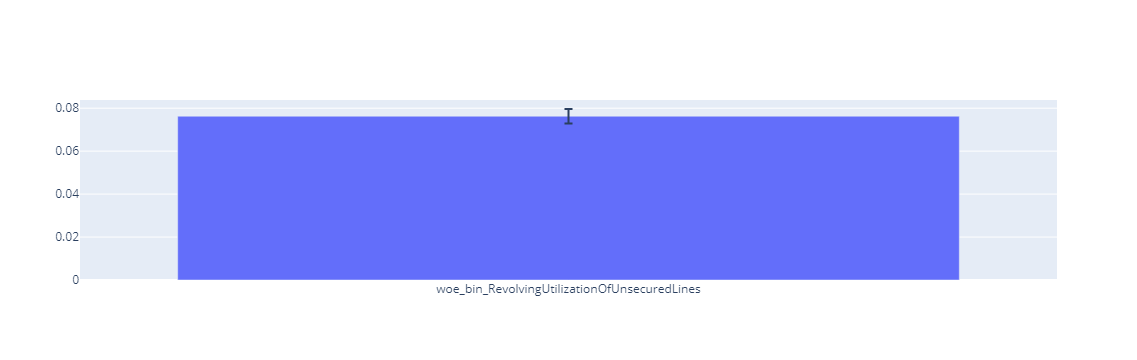

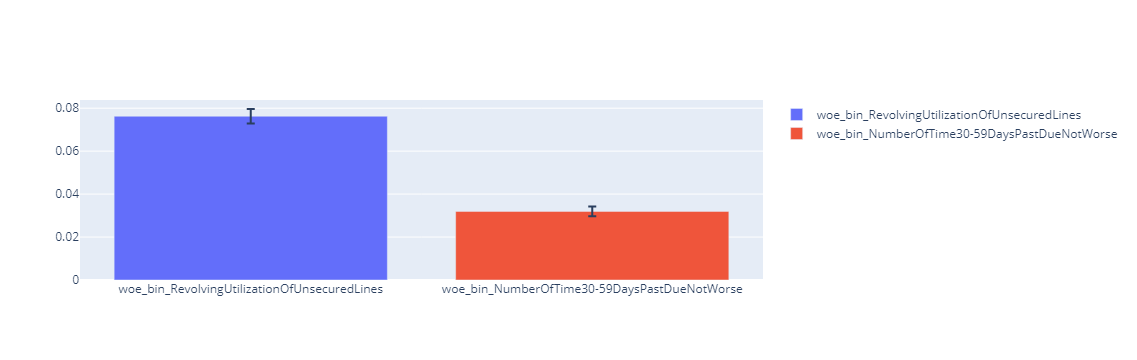

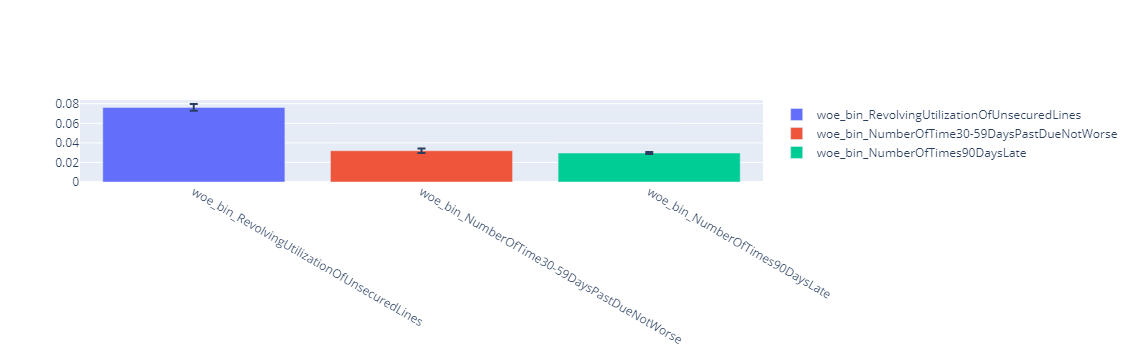

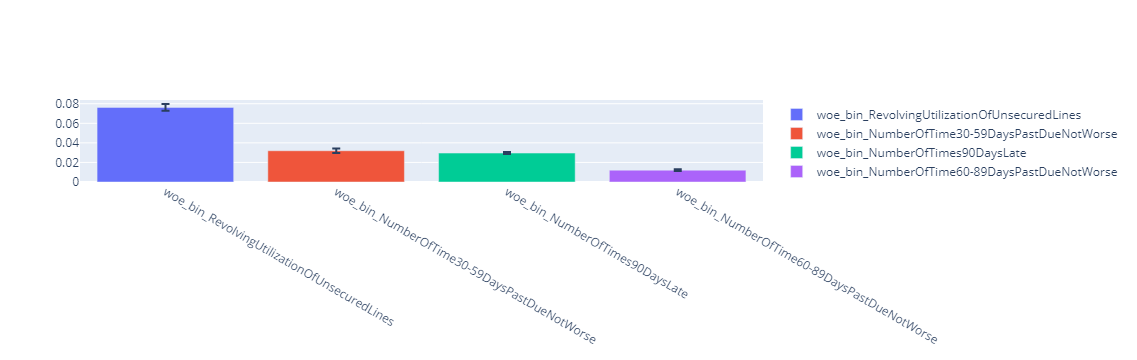

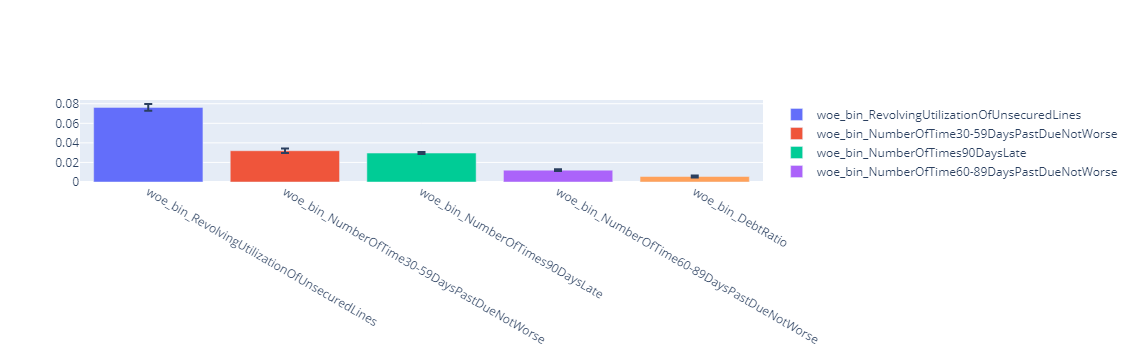

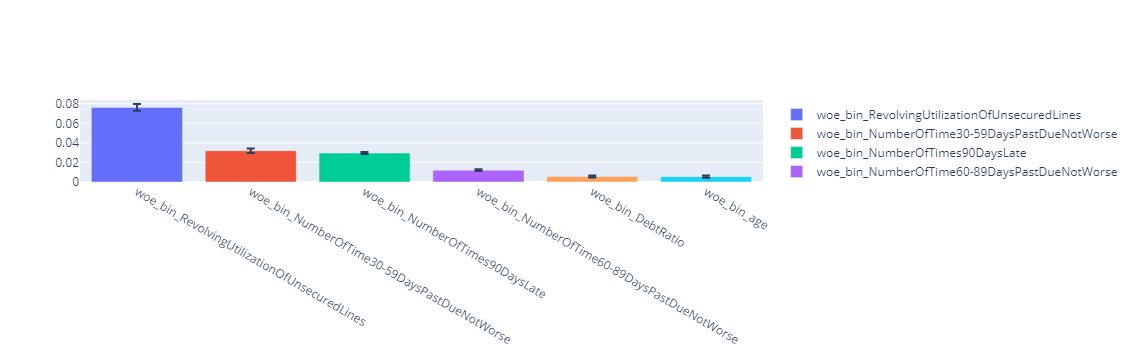

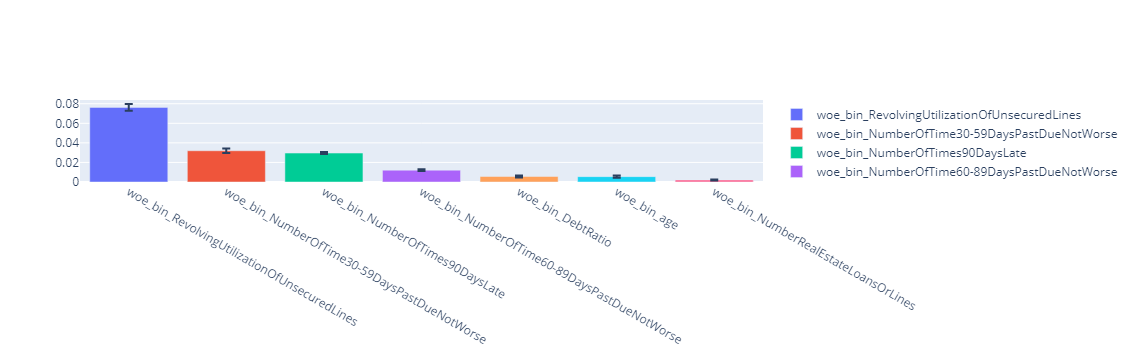

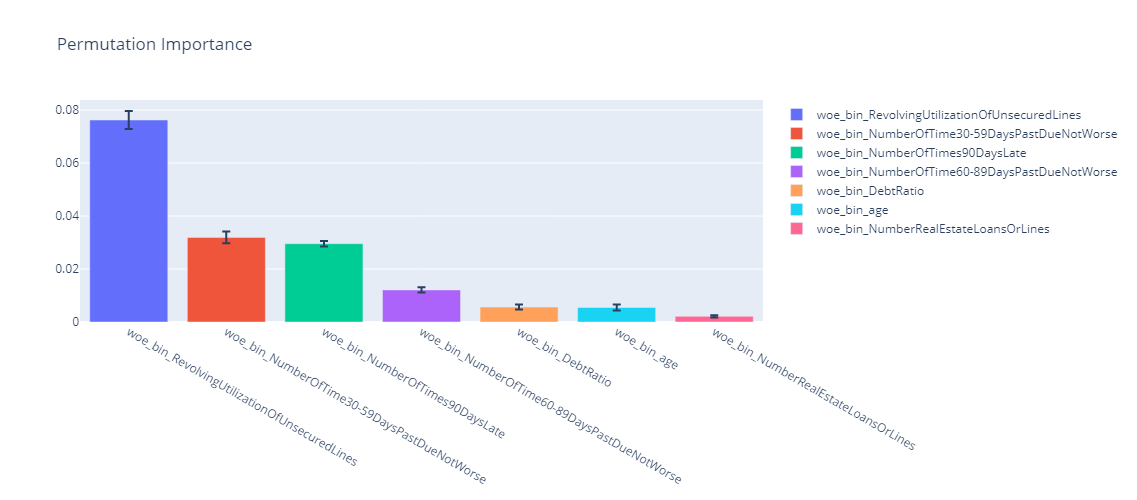

In [422]:
fig = go.Figure()
for i in range(importance_df.shape[0]) : 
    fig.add_trace(go.Bar(
        x=[importance_df.features[i]], y=[importance_df.mean_importance[i]],name=importance_df.features[i],
        error_y=dict(type='data', array=[importance_df.std_importance[i]])))
fig.update_layout(title='Permutation Importance',height=500,paper_bgcolor='#ffffff')

## Train Model on Full Dataset

In [423]:
X = binned_data[woe_col]
y = binned_data[TARGET]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

clf_model.fit(X,y)

LogisticRegression(class_weight='balanced')

## Create Scorecard Using Model Coefficient

In [448]:
binned_col = ['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTimes90DaysLate',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

In [449]:
def create_model_coef_dict(fitted_model,feature_names) : 
    reference = {}
    for x,y in zip (feature_names,clf_model.coef_.tolist()[0]) : 
        reference[x] = y
    return reference

In [450]:
model_coef = create_model_coef_dict(clf_model,feature_names=binned_col)

In [451]:
model_coef

{'bin_age': -0.45307556641458385,
 'bin_NumberOfDependents': -0.2311175188405515,
 'bin_NumberOfTimes90DaysLate': -0.6261959070381328,
 'bin_NumberOfTime30-59DaysPastDueNotWorse': -0.6342808955728055,
 'bin_NumberOfTime60-89DaysPastDueNotWorse': -0.5195180941876831,
 'bin_RevolvingUtilizationOfUnsecuredLines': -0.6373305587623068,
 'bin_DebtRatio': -0.7144885473210958,
 'bin_MonthlyIncome': -0.1790008935564025,
 'bin_NumberOfOpenCreditLinesAndLoans': -0.06494254369324687,
 'bin_NumberRealEstateLoansOrLines': -0.8179731440771433}

In [439]:
# odds 50 to 1 at 650 pdo 20 
650 -(28.8539*np.log(50))

537.1228794036768

In [440]:
def create_score_card(model_coef_dict,factor=28.8539) :
    temp = []
    for key in woe_reference : 
        data = pd.DataFrame()

        ref = woe_reference.get(key)
        data['bin'] = list(ref.keys())
        data['features'] = key
        data['woe'] = list(ref.values())
        data['woe']= data['woe'].apply(lambda x : x['woe'])
        data['woe'] = data['woe'].replace(np.inf,0)
        data['woe'] = data['woe'].replace(-np.inf,0)
        feature_coef = model_coef_dict.get(key)
        data['score'] = -feature_coef*data['woe']*factor
        data['score'] =data['score'].astype('int')
        temp.append(data)
    scorecard_df = pd.concat(temp)
    scoring_dict = {}
    for feature in scorecard_df.features.unique() : 
        scoring_dict[feature] = {}
        sliced_df = scorecard_df.loc[scorecard_df.features==feature]
        for binrange,score in zip(sliced_df['bin'],sliced_df['score']) : 
            scoring_dict[feature][binrange] =score
    return scorecard_df,scoring_dict

In [441]:
scorecard_df,scoring_dict =create_score_card(model_coef_dict=model_coef)

In [442]:
scorecard_df

,bin,features,woe,score
0,"(20.0, 25.0]",bin_age,-0.502978,-6
1,"(25.0, 30.0]",bin_age,-0.574484,-7
2,"(30.0, 35.0]",bin_age,-0.442731,-5
3,"(35.0, 40.0]",bin_age,-0.295249,-3
4,"(40.0, 45.0]",bin_age,-0.214938,-2
...,...,...,...,...
6,"(5.0, 6.0]",bin_NumberRealEstateLoansOrLines,-0.875653,-21
7,"(6.0, 7.0]",bin_NumberRealEstateLoansOrLines,-1.016220,-24
8,"(7.0, 8.0]",bin_NumberRealEstateLoansOrLines,-1.489278,-36
9,"(8.0, 9.0]",bin_NumberRealEstateLoansOrLines,-1.059746,-25


In [443]:
def apply_scoring(data,scoring_dict,feature_names:list,offset=537.1228794036768) : 
    for feature in feature_names : 
        #create new feature scorer 
        feature_dict = scoring_dict.get(feature)
        data[f'score_{feature}'] =data[feature].apply(lambda x:feature_dict.get(x))
        score_col = [x for x in data.columns if x.startswith('score_')]
        data['score'] = data[score_col].sum(axis=1) + offset
        data.drop(score_col,axis=1,inplace=True)
    return data

In [444]:
scored_data = apply_scoring(data=binned_data,scoring_dict=scoring_dict,feature_names=binned_col)

In [445]:

scored_data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,encoded_bin_NumberOfDependents,encoded_bin_NumberOfTimes90DaysLate,encoded_bin_NumberOfTime30-59DaysPastDueNotWorse,encoded_bin_NumberOfTime60-89DaysPastDueNotWorse,encoded_bin_RevolvingUtilizationOfUnsecuredLines,encoded_bin_DebtRatio,encoded_bin_MonthlyIncome,encoded_bin_NumberOfOpenCreditLinesAndLoans,encoded_bin_NumberRealEstateLoansOrLines,score
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,2,0,2,0,9,10,3,2,6,516.122
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,1,0,0,0,9,3,0,4,0,537.122
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,0,1,1,0,8,2,0,1,0,537.122
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0,0,0,0,6,2,1,5,0,537.122
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,0,0,1,0,9,2,4,7,0,537.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,...,0,0,0,0,7,7,1,7,0,537.122
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,0,0,0,0,3,4,0,4,0,537.122
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,2,0,0,0,7,10,2,4,0,537.122
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,0,0,0,0,0,0,2,4,0,537.122


## Setting Cutoff 
In this Scenario we will use  bad rate at 8.7% . Hence only applicant with score above 531 above will be accepted



In [446]:
crosstab_data = (pd.crosstab(scored_data['score'],
                             scored_data[TARGET],rownames=['score'], 
                             colnames=[TARGET])
                 .reset_index()
                )
crosstab_data['bad_rate'] = (crosstab_data[1] / (crosstab_data[0] + crosstab_data[1]))*100

In [447]:
crosstab_data

SeriousDlqin2yrs,score,0,1,bad_rate
0,501.122,52,17,24.637681
1,504.122,27,8,22.857143
2,509.122,46,11,19.298246
3,512.122,47,10,17.543860
4,513.122,108,22,16.923077
5,516.122,226,40,15.037594
6,521.122,484,71,12.792793
7,531.122,1616,154,8.700565
8,537.122,82499,6257,7.049664
9,541.122,24263,1474,5.727163


## Generate Prediction 

In [128]:
test_data = pd.read_csv(TEST_DATA_PATH)

In [129]:
#filling missing value 
##Imputation 
test_data['MonthlyIncome'] = test_data['MonthlyIncome'].fillna(data['MonthlyIncome'].median())
test_data['NumberOfDependents'] = test_data['NumberOfDependents'].fillna(data['NumberOfDependents'].mode()[0])

In [130]:
test_binned_data = create_binning(test_data)

In [131]:
test_binned_data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'bin_age', 'bin_NumberOfDependents',
       'bin_NumberOfTimes90DaysLate',
       'bin_NumberOfTime30-59DaysPastDueNotWorse',
       'bin_NumberOfTime60-89DaysPastDueNotWorse',
       'bin_RevolvingUtilizationOfUnsecuredLines', 'bin_DebtRatio',
       'bin_MonthlyIncome', 'bin_NumberOfOpenCreditLinesAndLoans',
       'bin_NumberRealEstateLoansOrLines'],
      dtype='object')

In [132]:
binned_col = [x for x in test_binned_data.columns if x.startswith('bin')]

In [133]:
for feature in binned_col :
	test_binned_data[f'woe_{feature}'] = test_binned_data[feature].apply(get_woe_value,col=feature)

value of x : (8.0, 9.0], col = bin_NumberOfTime60-89DaysPastDueNotWorse
value of x : (8.0, 9.0], col = bin_NumberOfTime60-89DaysPastDueNotWorse
value of x : (8.0, 9.0], col = bin_NumberOfTime60-89DaysPastDueNotWorse


In [134]:
woe_reference['bin_NumberOfTime60-89DaysPastDueNotWorse']

{'(-inf, 0.0]': {'woe': 0.2740025289064378, 'iv': 0.06333198744667347},
 '(0.0, 1.0]': {'woe': -1.7688631189946284, 'iv': 0.2536348158507391},
 '(1.0, 2.0]': {'woe': -2.602602740263266, 'iv': 0.12670578496938556},
 '(10.0, inf]': {'woe': -2.9214239608206145, 'iv': 0.03941837485538247},
 '(2.0, 3.0]': {'woe': -2.8949907037524594, 'iv': 0.04883748307021512},
 '(3.0, 4.0]': {'woe': -2.939442466323293, 'iv': 0.01588072441014534},
 '(4.0, 5.0]': {'woe': -2.7614593111279366, 'iv': 0.0044912092656616345},
 '(5.0, 6.0]': {'woe': -3.6189095429791585, 'iv': 0.004804151390455038},
 '(6.0, 7.0]': {'woe': -2.607308631300678, 'iv': 0.0005989743742358782},
 '(7.0, 8.0]': {'woe': -2.607308631300678, 'iv': 0.0002994871871179391}}

In [135]:
woe_col = [x for x in test_binned_data.columns if x.startswith('woe')]

In [136]:
test_feature_engineered_data = test_binned_data[woe_col]

In [137]:
test_feature_engineered_data= test_feature_engineered_data.replace([np.inf, -np.inf], 0)

In [138]:
prediction = clf_model.predict_proba(test_feature_engineered_data)[:,1]

In [139]:
prediction

array([0.477556  , 0.38116132, 0.22109272, ..., 0.18189198, 0.60904554,
       0.33588799])

## Read Sample Submission

In [140]:
submission = pd.read_csv(SAMPLE_SUBMISSION)

In [141]:
submission['Probability'] = prediction

In [142]:
submission.to_csv('Submission_woe.csv',index=False)